In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


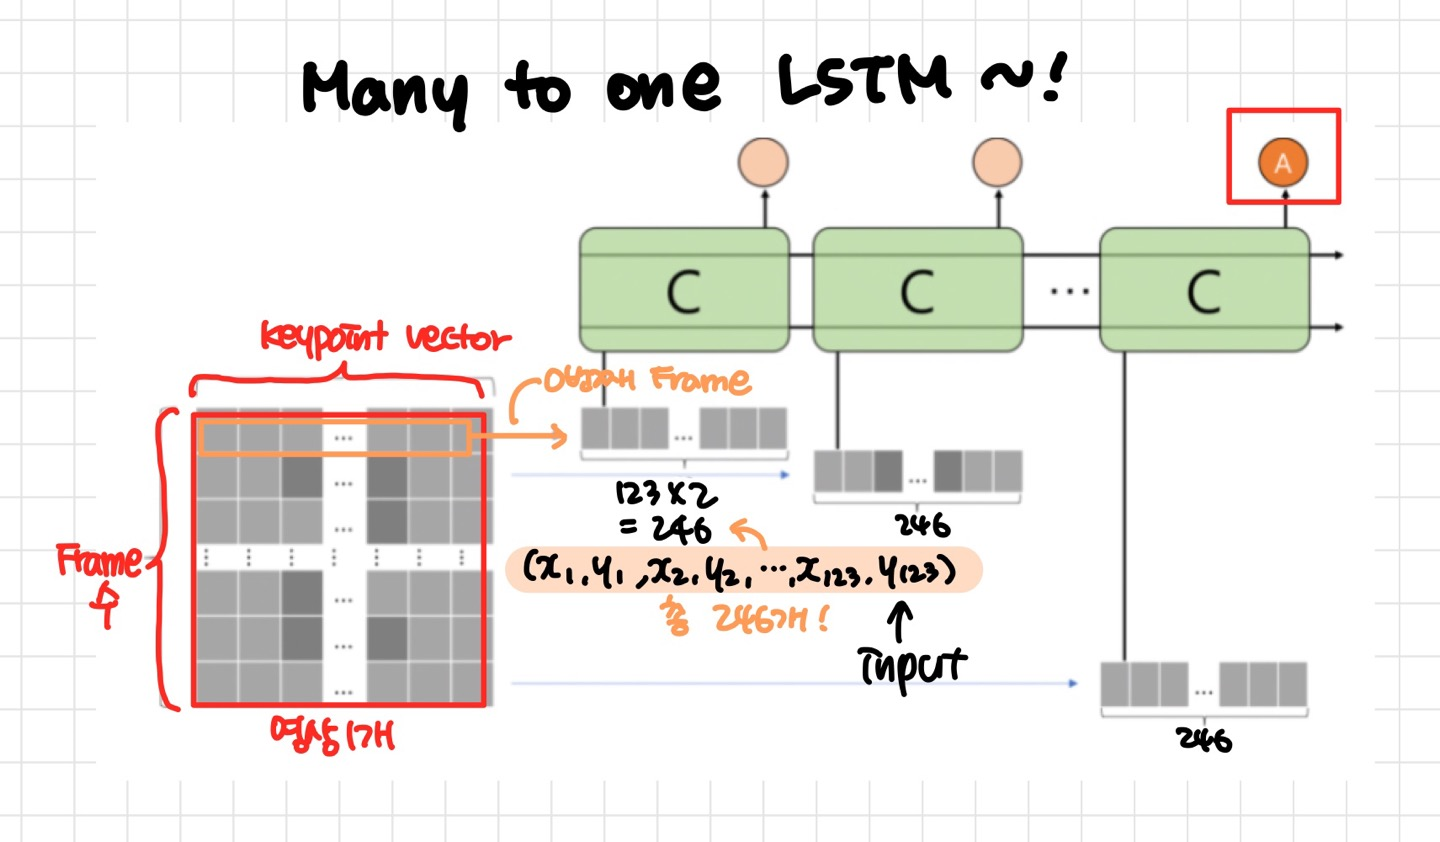

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM, Dense
import json

In [ ]:
path = '/content/drive/MyDrive/BOAZ_수어프로젝트/Data/alphapose/12654_12994_alphapose/'

In [ ]:
import json

#for i in ls:
with open(path +'alphapose-results.json' ,'r') as f:
  data = json.load(f)

In [ ]:
import re
new=[]
a =12654
for i in data:
  num2 = i.split('_')[3]
  num2 = re.sub(".jpg", "", num2)

  if 12<=int(num2)<=92:
    dt = data[i]['keypoints']
    dt = np.array(dt).reshape(123,2)
    flat = [dt[i][j] for i in range(np.array(dt).shape[0]) for j in range(np.array(dt).shape[1])]
    new.append(flat)
  else:
    a=a+1

In [ ]:
np.array(new).shape

(27540, 246)

In [ ]:
27540/81

340.0

In [ ]:
# (영상개수,frame수, keypoint개수(/2하면 x,y각각의 개수))

new = np.array(new)
new = new.reshape(340,81,246)

In [ ]:
# target 임시로 가져오기
# 영상 번호 12654_12994

import pandas as pd

target = pd.read_excel('/content/drive/MyDrive/BOAZ_수어프로젝트/Data/openpose/target.xlsx')

In [ ]:
target.columns=['word']
target= target['word']

target

0       79
1       80
2       81
3       82
4       83
      ... 
335     화상
336     화약
337    화요일
338    화장실
339     화재
Name: word, Length: 340, dtype: object

In [ ]:
target = target[30:]

In [ ]:
Y=np.asarray(target).reshape(-1,1)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
enc.fit(Y)

OneHotEncoder()

In [ ]:
encoding = enc.transform(Y).toarray()

In [ ]:
encoding

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [ ]:
#new = np.array(new)
#new.reshape(340,81,246)
new = new[30:,:,:]
new.shape

(310, 81, 246)

In [ ]:
encoding.shape

(310, 310)

## Pytorch 구현..

In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

# Device Settings
device = torch.device('cuda' if torch.cuda.is_available else 'cpu')
print('device : ', device)

device :  cuda


In [ ]:
# Hyperparameter Setting


sequence_length = 81 # frame 수
input_size = 246 # keypoint vector 길이
hidden_size = 128
num_layers = 2
num_classes = encoding.shape[0]
batch_size = 310
num_epochs = 30
learning_rate = 0.01

In [ ]:
# RNN class 정의 (many-to-one으로) -> Encoder


class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__() 
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        #우리는 이미 keypoint(숫자)를 이용하기 때문에 embedding이 필요 X

        
    def forward(self, x): 
        # input x : (BATCH, LENGTH, INPUT_SIZE)임  (다양한 length를 다룰 수 있습니다.).
        # 최초의 hidden state와 cell state를 초기화
        # 배치 사이즈는 가변적이므로 클래스 내에선 표현 X
         
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # (BATCH SIZE, SEQ_LENGTH, HIDDEN_SIZE)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device) # hidden state와 동일

        # LSTM 순전파
        out, _ = self.lstm(x, (h0, c0)) # output : (BATCH_SIZE, SEQ_LENGTH, HIDDEN_SIZE) tensors. (hn, cn)은 필요 없으므로 받지 않고 _로 처리합니다. 

        # 마지막 time step(sequence length)의 hidden state를 사용해 Class들의 logit을 반환합니다(hidden_size -> num_classes). 
        out = self.fc(out[:, -1, :])
        
        return out

In [ ]:
# 모델 할당 후 학습
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

# 손실 함수와 옵티마이저 정의
criterion = nn.CrossEntropyLoss() # 분류
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [ ]:

# torch.tensor 형태로 변환해주기 !!!!! pytorch는 torch~~~
# 이때 float안해주니까 오류남 
# dtype 맞춰주기(hidden이랑 input이랑) -> pytorch는 둘의 dtype이 다르면 연산이 안된다는 특징가진다했 나 ?
Y = torch.from_numpy(encoding).float()
X = torch.from_numpy(new).float()

# 학습
total_step = len(X) # 배치 개수
for epoch in range(num_epochs):
    for i, keypoints in enumerate(X):
      
      
      keypoints = keypoints.reshape(-1, sequence_length, input_size).to(device)
      labels = Y[i].to(device) 
    

      # 순전파
      outputs = model(keypoints)
      labels = labels.reshape(1,310)
      loss = criterion(outputs, labels)

      # 역전파 & 최적화
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if (i+1) % 100 == 0:
        print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(
            epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/30], Step [100/310], Loss: 6.1254
Epoch [1/30], Step [200/310], Loss: 6.7081
Epoch [1/30], Step [300/310], Loss: 7.3060
Epoch [2/30], Step [100/310], Loss: 7.6497
Epoch [2/30], Step [200/310], Loss: 7.1468
Epoch [2/30], Step [300/310], Loss: 7.2011
Epoch [3/30], Step [100/310], Loss: 9.5626
Epoch [3/30], Step [200/310], Loss: 11.4398
Epoch [3/30], Step [300/310], Loss: 8.6690
Epoch [4/30], Step [100/310], Loss: 7.5984
Epoch [4/30], Step [200/310], Loss: 7.1651
Epoch [4/30], Step [300/310], Loss: 8.2210
Epoch [5/30], Step [100/310], Loss: 8.2810
Epoch [5/30], Step [200/310], Loss: 7.9281
Epoch [5/30], Step [300/310], Loss: 7.7765
Epoch [6/30], Step [100/310], Loss: 10.2014
Epoch [6/30], Step [200/310], Loss: 7.3188
Epoch [6/30], Step [300/310], Loss: 8.1395
Epoch [7/30], Step [100/310], Loss: 7.2069
Epoch [7/30], Step [200/310], Loss: 7.3432
Epoch [7/30], Step [300/310], Loss: 7.2480
Epoch [8/30], Step [100/310], Loss: 7.2412
Epoch [8/30], Step [200/310], Loss: 7.2585
Epoch [8/

## Tensorflow implement

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM, Dense

model = keras.Sequential()
model.add(LSTM(20,activation='relu',input_shape=(81,246)))
model.add(Dense(310))

model.compile(optimizer='adam', loss='categorical_crossentropy')
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20)                21360     
                                                                 
 dense (Dense)               (None, 310)               6510      
                                                                 
Total params: 27,870
Trainable params: 27,870
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

import matplotlib.pyplot as plt
import os
import numpy

history = model.fit(new,encoding, epochs=20, batch_size=1, verbose=1, validation_split=0.2)


y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Loss")
plt.plot(x_len, y_loss, marker='.', c='blue', label="Train-set Loss")

plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

Epoch 1/20
248/248 [==============================] - 15s 53ms/step - loss: 9.2390 - val_loss: 8.1483
Epoch 2/20
248/248 [==============================] - 13s 53ms/step - loss: 8.8229 - val_loss: 8.1800
Epoch 3/20
248/248 [==============================] - 13s 53ms/step - loss: 8.8817 - val_loss: 9.1207
Epoch 4/20
158/248 [==================>...........] - ETA: 4s - loss: 7.5813

KeyboardInterrupt: ignored